In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import mpld3
from mpld3 import plugins

from pyspark.mllib.stat import Statistics
%matplotlib inline

import findspark
findspark.init()

# Import and start a Spark session.
from pyspark.sql import *
import pyspark.sql.functions as F
from pyspark.sql.types import DoubleType, StringType

spark = SparkSession.builder.getOrCreate()
plt.rcParams['figure.figsize'] = [12, 8]

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set default figure styles using Seaborn.
sns.set()
sns.set_style(rc={'patch.edgecolor': 'black'})
matplotlib.rcParams['figure.figsize'] = [12, 8]

# Analyze of hashtags as a whole

The first part of our work is the analysis of how hashtags behave. Here, we want to understand the general behavior. A more precise analyse on specific hashtags will come latter.

## Creating our datasets

As the twitter dataset is huge, we can't work directly on it, we must find a way to extract insights from it that are usefull from our analysis. We are particularly interested in two metrics: 
- the count of tweets having a given hashtag
- the exposure (which we are calling "print") of tweets having a given hashtag. The exposure of a tweet is defined as an approximation of the audience reached by it, which is approximately the number of followers of the author. Then, we can approximate the exposure of several tweets by the sums of the followers of every authors. This is an over approximation as some users could have common followers, but it should be good enough.

Then, for each hashtag $h$ we are extracting the following insights:
- the total count of tweets having the hashtag $h$
- for each day the total count of tweets having the hashtag $h$ and tweeted on this day
- the exposure of tweets having the hashtag $h$
- for each day the exposure of tweets having the hashtag $h$ and tweeted on this day

More concretely, we ran the script `hashtag_insights.py` for each month on the cluster. Then, we merged the insights of different months as explained below.

### Merging of monthly insights into an insights dataframe.

We start by loading our monthly insights extracted from the cluster. We load every month of 2017 at the exception of:
- January, as we never managed to open it on the cluster
- June, as it contain nearly no data on the cluster
- December as it was absent of the cluster

In [26]:
def load_insights(months):
    return {month: spark.read.parquet('hashtags_insights_{}.parquet'.format(month)) for month in months} 

hashtags = load_insights(['02', '03', '04', '05', '07', '08', '09', '10', '11'])

For reasons we didn't understood, our hashtags insights for the month of augusts contained some duplicates rows. Hence, we remove them before continuing our analysis.

In [ ]:
hashtags['08'] = hashtags['08'].dropDuplicates()

For each monthly hashtags, some days could be absent (which is the case for the month of November where the 19th, 20th, 21st, 22nd, 23rd, 24th and 25th are missing). We remove the corresponding rows. For rows that still exists we prefix them. As rows `count` and `print` can be recomputed easily, to avoid any conflicts when joining the monthly insights we remove them.

In [ ]:
def rename_columns(insights, prefix):
    printCols = [c for c in insights.columns if "print_" in c]
    nameCols = [c for c in insights.columns if "count_" in c]
    print(insights, prefix)
    for x in printCols + nameCols:
        if insights.where(F.col(x) != 0).count() == 0:
            insights = insights.drop(x)
        else:
            insights = insights.withColumnRenamed(x, prefix + "_" + x)
    return insights.drop("count").drop("print")

In [ ]:
insights = [rename_columns(hashtags[key], key) for key in hashtags]

We now join every monthly hashtags by using an outer join.

In [ ]:
from functools import reduce

def joinAll(dfs):
    return reduce(lambda prev, cur: cur.join(prev, on='tag', how='outer'), dfs)

In [ ]:
unifiedInsights = joinAll(insights)

We then replace Nan entries by 0 and we recompute rows `count` and `print`.

In [ ]:
unifiedInsights = unifiedInsights.fillna(0).cache()
count_columns = [c for c in unifiedInsights.columns if "count" in c]
unifiedInsights = unifiedInsights.withColumn("count", sum(F.col(c) for c in count_columns))
print_columns = [c for c in unifiedInsights.columns if "print" in c]
unifiedInsights = unifiedInsights.withColumn("print", sum(F.col(c) for c in print_columns))

Finally we export this dataset to a parquet file.

In [ ]:
unifiedInsights.write.mode("overwrite").parquet("hashtags-insights.parquet")

### Building a "compressed insights" from our insights.

For convenience, we also decided to build a new dataset from the previous one. The main difference is in how we store the count per day and the print per day. In the previous dataset we had one column per day for the count and the exposure. In the one we will be building, we will have a row which will be an array of counts, and a row which will be an array of exposure (the ith entry maps to day i). These arrays will be relative to the row count and print, that is normalized between 0 and 1. This allows us to compare the behavior of two hashtags more accurately.

In [232]:
insights = spark.read.parquet("hashtags-insights.parquet")

We first build a time-sorted list of names of columns corresponding to a hashtag count. We also build the equivalent for the exposure.

In [233]:
def key(c):
    """ Parse a column name of the form month_(print|count)_day in a tuple (month, day)"""
    month, _, day = c.split("_")
    return int(month), int(day)


count_columns_wkey = [(c, key(c)) for c in insights.columns if "count_" in c]
count_columns_wkey.sort(key=lambda x: x[1])
count_columns = [a for a, _ in count_columns_wkey]
count_days = [b for _, b in count_columns_wkey]

print_columns_wkey = [(c, key(c)) for c in insights.columns if "print_" in c]
print_columns_wkey.sort(key=lambda x: x[1])
print_columns = [a for a, _ in print_columns_wkey]
print_days = [b for _, b in print_columns_wkey]

We create a new column `count_daily` which will be the array of normalized daily counts and drop the columns that have become useless.

In [ ]:
insights_compressed = \
    insights \
    .withColumn("count_daily", F.array(*[F.col(c) / F.col('count') for c in count_columns])) \
    .select(*[c for c in insights_compressed.columns if not c in count_columns])

We know do the same to add `print_daily`, which is the equivalent of `count_daily` but for the exposure.

In [ ]:
insights_compressed = \
    insights_compressed \
    .withColumn("print_daily", F.array(*[F.col(c) / F.col('print') for c in print_columns])) \
    .select(*[c for c in insights_compressed.columns if not c in print_columns])

Then we export the resulting dataset to a parquet file.

In [ ]:
insights_compressed.write.parquet("insights-compressed.parquet")

### Cleaning up the followers dataset

We also extracted from the clusters a dataset of the users who tweeted in july. This dataset is of the form (user id, number of followers).

Unfortunately this dataset as multiple duplicates. We will remove them and also compute the number of tweets in which a user took part. 

In [4]:
followers = spark.read.parquet("followers_count_07.parquet")

In [5]:
followers_unique = \
    followers \
    .groupby('userID') \
    .agg(F.count(F.lit(1)).alias('n_tweets'), F.max(F.col('followersCount')).alias('followersCount')) \
    .cache()

We have more than 25million distinct users:

In [6]:
followers_unique.count()

27602081

Finally we can export the dataset.

In [ ]:
followers_unique.write.parquet('followers.parquet')

## Analysis of hashtags insight

We start by loading our two datasets:

In [3]:
insights = spark.read.parquet("data/hashtags-insights.parquet")

In [4]:
insights_compressed = spark.read.parquet("data/insights-compressed.parquet")

In [5]:
insights.cache()
insights_compressed.cache()

DataFrame[tag: string, count: bigint, print: bigint, count_daily: array<double>, print_daily: array<double>]

### General statistics

We have around 15 million different hashtags in the dataset.

In [5]:
insights.count()

15177260

The average exposure is of 134 thousand people, while on average an hashtag appears 21 time in our dataset. Do not forget that we extracted the hashtags from a 1% sample of twitter, hence the truth is that the true average of the number of occurences is more likely to be around 2100.

In [34]:
insights.agg({"count": "avg", "print": "avg"}).show()

+------------------+------------------+
|        avg(print)|        avg(count)|
+------------------+------------------+
|134616.39214831925|21.220559969322526|
+------------------+------------------+



However, the average count, and even the average print are completly biased by the outliers. The median of the count is 1!

In [44]:
insights.approxQuantile('count', [.25, .5, .75], .001)

[1.0, 1.0, 3.0]

In [38]:
insights.approxQuantile('print', [.25, .5, .75], .001)

[143.0, 710.0, 3968.0]

**Analyse of the distribution of the number of occurences**

In fact, only 38% of the hashtags are present more than once.

In [51]:
100 * float(insights.where(F.col('count') > 1).count()) / float(insights.count())

38.79508554244969

More surprisingly, .78% of hashtags are present at least 250 times. 

In [224]:
100 * float(insights.where(F.col('count') > 250).count()) / float(insights.count())

0.7877377075967599

Starting from now, we will pursue our analysis only on hashtags occuring more than 250 times: this a good compromise about "generality" and focusing on "viral" tweets.

In [6]:
THRESHOLD_COUNT = 250

The histogram of the number of occurrences shows clearly that the number of occurrences is sharply decreasing.
The noise at the start of the histogram might be due to the sampling: missing one tweet out of 50 is more impactfull than one tweet out of 250. 

In [424]:
bins, counts = insights.where(F.col('count') > 50) \
        .select(F.log10('count')).rdd \
        .flatMap(lambda x: x) \
        .histogram(150)

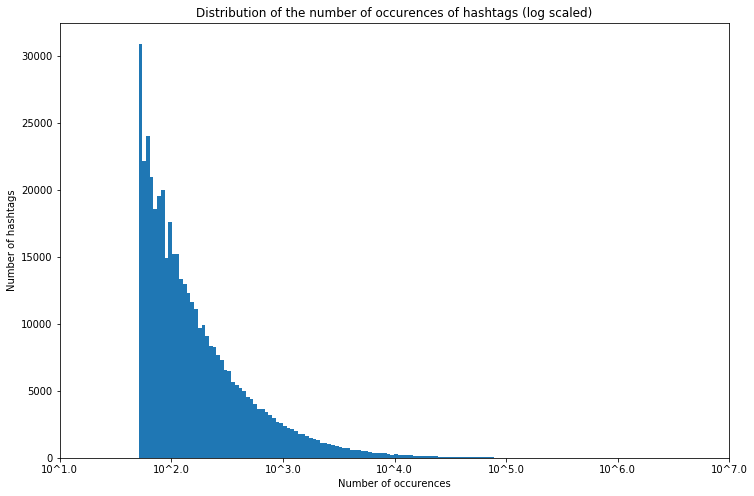

In [425]:
plt.hist(bins[:-1], bins=bins, weights=counts)
plt.title('Distribution of the number of occurences of hashtags (log scaled)' )
plt.ylabel('Number of hashtags')
plt.xlabel('Number of occurences')
locs, _ = plt.xticks()
labels = ["10^{}".format(l) for l in locs]
plt.xticks(locs, labels);

In fact, it is even following a power-law:

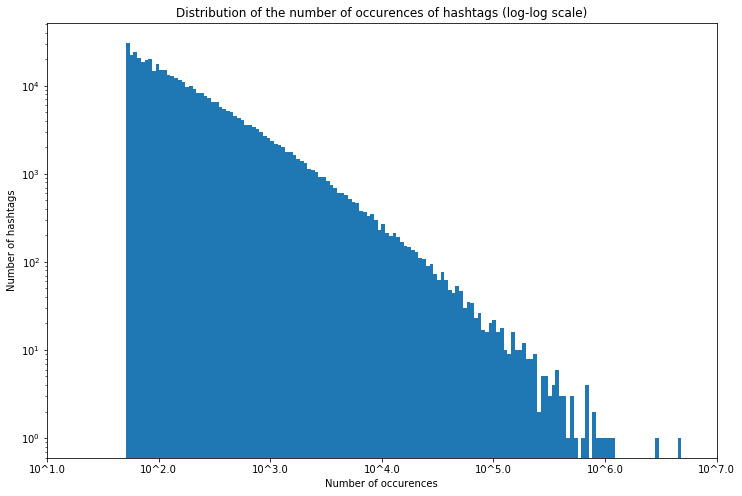

In [98]:
plt.hist(bins[:-1], bins=bins, weights=counts, log=True)
plt.title('Distribution of the number of occurences of hashtags (log-log scale)' )
plt.ylabel('Number of hashtags')
plt.xlabel('Number of occurences')
locs, _ = plt.xticks()
labels = ["10^{}".format(l) for l in locs]
plt.xticks(locs, labels);

We finally plot the log-log histogram for all the values, to use in the data story.

In [6]:
bins, counts = insights.select(F.log10('count')).rdd \
        .flatMap(lambda x: x) \
        .histogram(150)

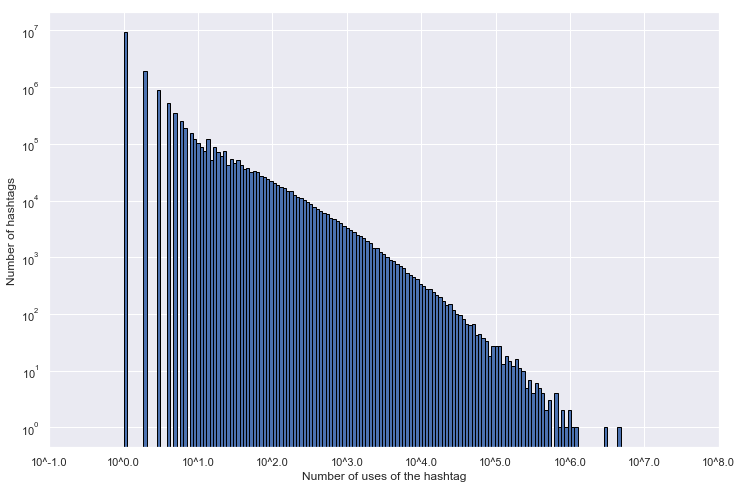

In [10]:
plt.hist(bins[:-1], bins=bins, weights=counts, log=True)
plt.ylabel('Number of hashtags')
plt.xlabel('Number of uses of the hashtag')
locs, _ = plt.xticks()
labels = ["10^{}".format(l) for l in locs]
plt.xticks(locs, labels);

We also check to which extent this distribution follows the Pareto principle.

In [27]:
# Total count of hashtags uses.
insights.select(F.sum('count')).collect()

[Row(sum(count)=322069956)]

In [50]:
# Top 1% of hashtags.
top_hashtags = insights.where(F.col('count') > 50).sort('count', ascending=False).limit(insights.count() // 100)

In [51]:
# Count of hashtag uses for the top 1% hashtags.
top_hashtags.select(F.sum('count')).collect()

[Row(sum(count)=247486969)]

In [54]:
top_hashtags_usage = 100*247486969/322069956
top_hashtags_usage

76.84261272727966

So we actually get something even more radical: the top 1% of hashtags accounts for more than 75% of hashtag use on Twitter.

**Analyse of the distribution of the exposure**

Once again we plot the log distribution of the exposure. We chose to use a threshold of 250000: only 2.9% of the tweets have a bigger exposure.

In [226]:
100 * float(insights.where(F.col('print') > 250000).count()) / float(insights.count())

2.869944904416212

In [55]:
bins, counts = insights.where(F.col('print') > 1) \
        .select(F.log10('print')).rdd \
        .flatMap(lambda x: x) \
        .histogram(150)

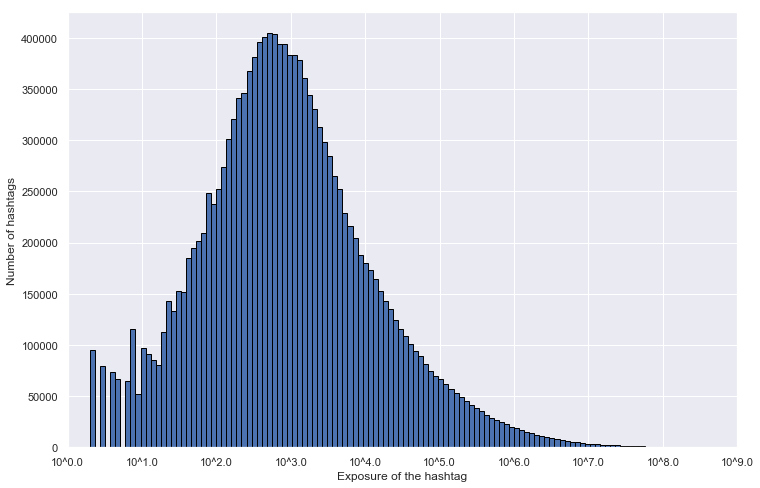

In [64]:
plt.hist(bins[:-1], bins=bins, weights=counts)
plt.ylabel('Number of hashtags')
plt.xlabel('Exposure of the hashtag')
axes = plt.gca()
axes.set_xlim([0, 9])
locs, _ = plt.xticks()
labels = ["10^{}".format(l) for l in locs]
plt.xticks(locs, labels);

In [76]:
# Total number of hashtags seen more than ten million times.
sum([counts[i] for (i, b) in enumerate(bins[:-1]) if b > 7])

24344

We were suprised by this bell shape curve. As the way we are building the exposure is strongly linked to the number of followers, we decided to extract the number of followers for all users having twitted in July 2017. As there are 110 millions of these users, the data obtained is quite reliable. Below you can find the histogram of the number of users.

In [8]:
followers = spark.read.parquet("followers.parquet")

In [10]:
bins, counts = followers \
        .select(F.log10('followersCount')).rdd \
        .flatMap(lambda x: x) \
        .histogram(150)

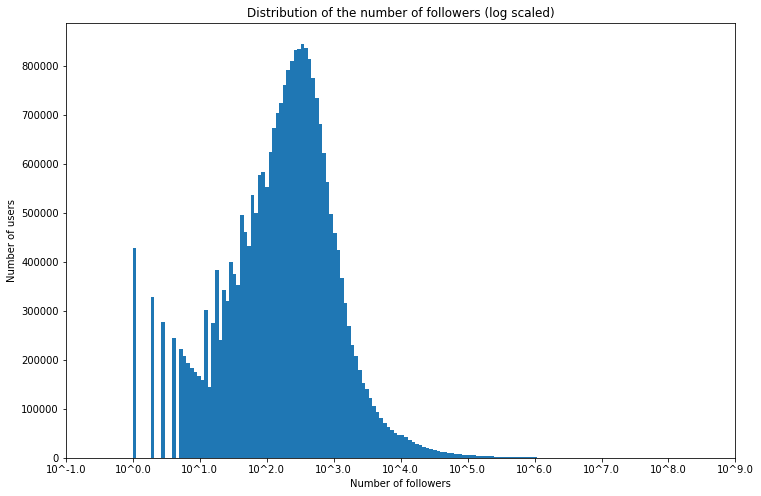

In [11]:
plt.hist(bins[:-1], bins=bins, weights=counts)
plt.title('Distribution of the number of followers (log scaled)' )
plt.ylabel('Number of users')
plt.xlabel('Number of followers')
locs, _ = plt.xticks()
labels = ["10^{}".format(l) for l in locs]
plt.xticks(locs, labels);

Surprisingly, the distribution of the exposure and of the number of followers have exactly the same shape! 

We can also note that the median of followers per users is 189.

In [12]:
followers.approxQuantile('followersCount', [.5], .001)

[189.0]

In [7]:
insights_r = insights.where(F.col('count') > THRESHOLD_COUNT)
insights_r.cache();

### Correlation between exposure and number of occurence.

Our intuition is that the exposure of a given hashtag, and its number of occurences are correlated. We wanted to validate this hypothesis by checking it on the dataset.

The first step is to compute spearman correlation coefficient. At 0.45, we can hope for the exposure and the number of occurences to be correlated.

In [143]:
features = insights_r.select("count", "print").rdd.map(lambda row: row[0:])
corr = Statistics.corr(features, method="spearman")

In [144]:
corr[0][1]

0.45635800425950807

However, it is always usefull to check our results visually. We first plot all points (count, print) in a scatter plot.

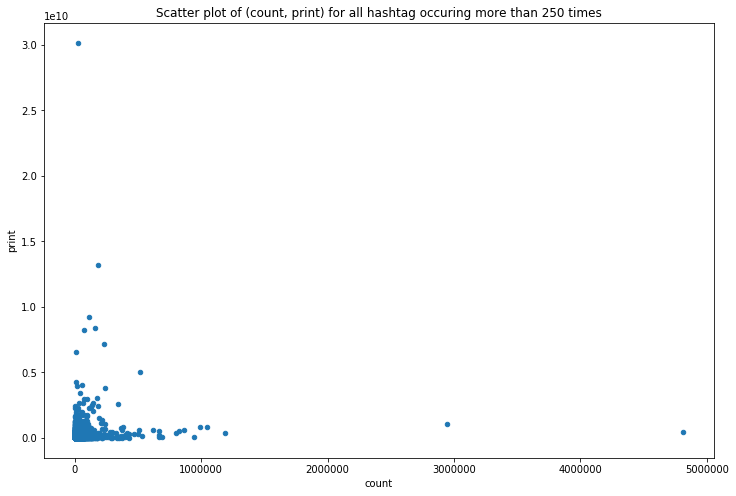

In [216]:
# the projection is small enough to fit in memory
sample = insights_r.select("tag", "count", "print").toPandas()
sample.plot.scatter('count', 'print')
plt.title('Scatter plot of (count, print) for all hashtag occuring more than 250 times');

Most of our data is in the bottom left corner. We will zoom on this corner.

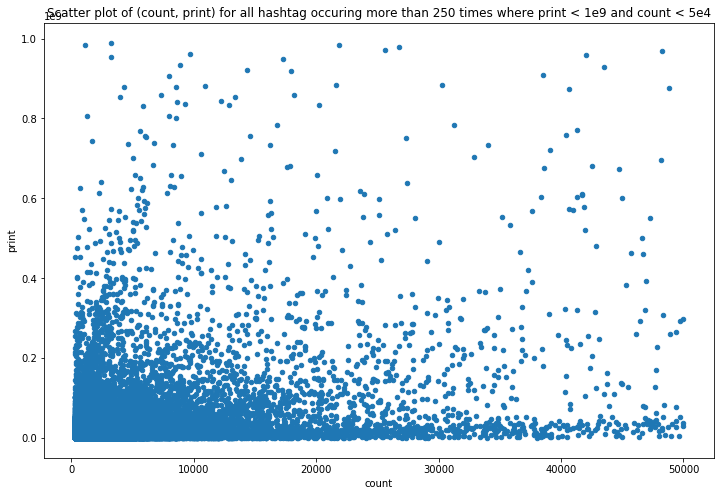

In [223]:
sample = \
    insights_r \
    .where((F.col('count') < 50000) & (F.col('print') < .1 * 1e10)) \
    .select("tag", "count", "print") \
    .toPandas()
sample.plot.scatter('count', 'print')
plt.title('Scatter plot of (count, print) for all hashtag occuring more than 250 times where print < 1e9 and count < 5e4');

Even zoomed in, we can't see a general trend. Most of the points seems to be clustered together.

We have two explanations of why we have not found a correlation between exposure and number of exposure:
- Either this correlation doesn't exists
- Either the exposure we computed is wrong. Right now it is highly dependant on who tweeted a tweet. For exemple, a user with one million follower will impact more the exposure than one thousand users with one hundred followers. However, given that users with a high number of followers are less numerous than other users, as our twitter sampled was uniformly sampled, this problem should not be present as it should have been compensated.

### Distribution of tweets

The distribution of tweets might be interesting to study. We will plot it below.

In [321]:
sum_count_day_pd = \
    insights_r \
    .agg(*[F.sum(F.col(c)).alias(c) for c in count_columns]) \
    .toPandas()

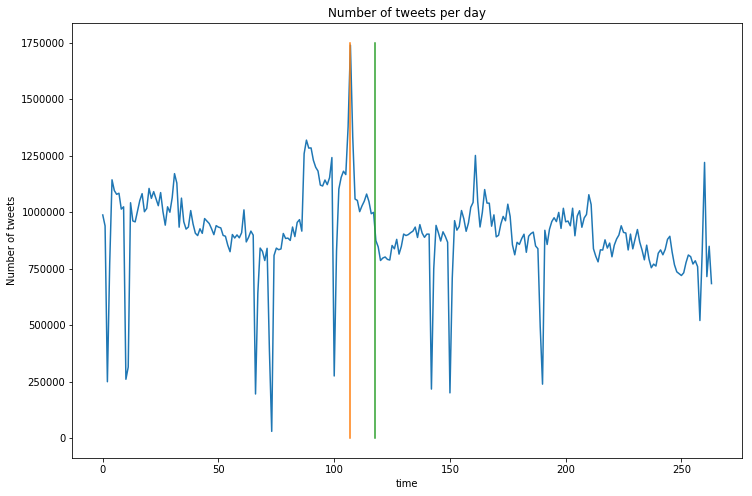

In [476]:
plt.plot(sum_count_day_pd.loc[0].values);
plt.title('Number of tweets per day')
plt.xlabel('time')
plt.ylabel('Number of tweets')
plt.plot([107, 107], [0, 1750000])
plt.plot([117.5, 117.5], [0, 1750000]);

Please keep in mind that some days (or even the full month of June) are missing. For example, here even the point with x coordinate 117 is the 31 may but the point with x coordinate 118 is the first July. This gap is represented by the green line.

The orange line is here to localize the maximum pike.

We also display the number of active hashtags per days. The orange pike is also represented on this graph.

In [319]:
sum_hashtags_day_pd = \
    insights_r \
    .agg(*[F.sum((F.col(c) > 0).cast('long')).alias(c) for c in count_columns]) \
    .toPandas()

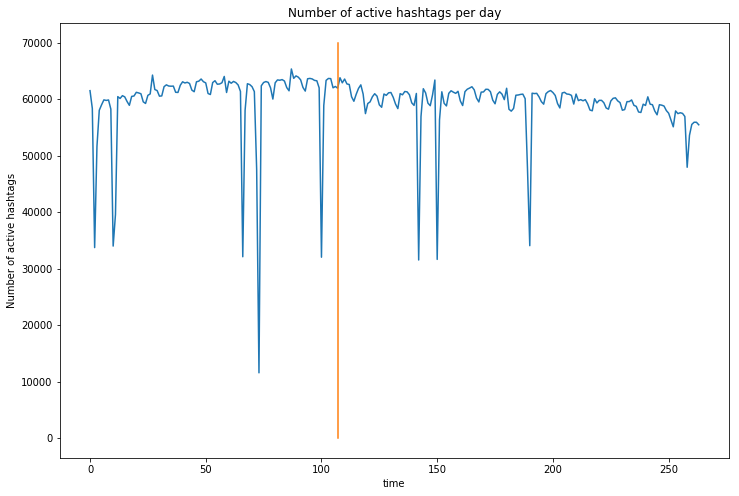

In [477]:
plt.plot(sum_hashtags_day_pd.loc[0].values);
plt.title('Number of active hashtags per day')
plt.xlabel('time')
plt.ylabel('Number of active hashtags')
plt.plot([107, 107], [0, 70000]);

Globally, the number of hashtags of per day is uniform accross 2017, which is something we could have expected. However, the two above graphs are showing some interesting facts:
- Each of the 9 sharp decrease in the number of tweets per day are also present as sharp decrease in the number of hashtags per day, and at the same position. This could hint us that on these days the sampling, or the transfer of the dataset had a problem.
- The maximum pike in the number of tweets per day is not visible on the second graph. This hints us toward a few hashtags which are more populars than others.

First we start by localizing the day where the pike occurs:

In [479]:
sum_count_day_pd.T[sum_count_day_pd.T[sum_count_day_pd.T.columns[0]] == sum_count_day_pd.T.max()[0]]

,0
05_count_21,1739101


This pike is on the 21st May 2017. After a quick search, we found out that billboard awards (or BBMAS) occured on the 22nd May 2017. However, when creating our hashtag insights, we converted dates to a datetime object which internally express times in UTC. It could be possible that due to timezones the event overlapped on the 21st May 2017 in UTC timezone.

We then select tweets which were twitted on this day.

To check our hypothesis, we select the hashtags tweeted on the 21st as well as on the 22nd and the 20th.

In [489]:
tags_25_21 = \
    insights \
    .where(F.col('05_count_21') > 0) \
    .select('tag', 'count', 'print', '05_count_21', '05_print_21') \
    .toPandas()
tags_25_22 = \
    insights \
    .where(F.col('05_count_22') > 0) \
    .select('tag', 'count', 'print', '05_count_22', '05_print_22') \
    .toPandas()
tags_25_20 = \
    insights \
    .where(F.col('05_count_20') > 0) \
    .select('tag', 'count', 'print', '05_count_20', '05_print_20') \
    .toPandas()

We now plot the most tweeted hashtags for the three days.

In [495]:
tags_25_21.sort_values('05_count_21', ascending=False).head(10)

,tag,count,print,05_count_21,05_print_21
187553,BTSBBMAs,2943069,1054566200,322129,113463234
139761,BBMAs,865828,591855353,114432,101628505
69683,topBBMAs,118118,46488146,37170,13344811
83831,NickiBBMAs,116431,101035896,33552,18085160
199892,izmirescort,4813484,473402849,26326,1520893
51766,PREMIOSMTVMIAW,798094,366569035,25916,8264276
82408,JustinBBMAs,201398,216706800,15545,15070525
218094,VeranoMTV2017,336345,33994283,14361,1640455
59799,MTVINSTAARVICICONTE,212576,138159858,11957,5547702
165441,TeamMendes,22173,12917511,10444,5081377


In [492]:
tags_25_22.sort_values('05_count_22', ascending=False).head()

,tag,count,print,05_count_22,05_print_22
144982,BBMAs,865828,591855353,112071,177617187
194720,BTSBBMAs,2943069,1054566200,51518,29270483
53751,PREMIOSMTVMIAW,798094,366569035,27395,6675467
275256,BTS,1048438,856258406,23001,16387958
147990,MTVSUPERCAEYOSS,215493,2772793,18070,118737


In [493]:
tags_25_20.sort_values('05_count_20', ascending=False).head()

,tag,count,print,05_count_20,05_print_20
190128,BTSBBMAs,2943069,1054566200,214983,71259469
52353,PREMIOSMTVMIAW,798094,366569035,30471,8312065
141979,BBMAs,865828,591855353,29334,10338314
202850,izmirescort,4813484,473402849,24796,1184615
85101,NickiBBMAs,116431,101035896,16035,8061344


Unsurprinsgly hashtags linked to BBMAS' are the hashtags the most tweeted on these days. Moreover, the most tweeted hashtags on the 21st are more tweeted than the ones on the 20th or the 22nd and by far. Add to that that a tweet can contain several hashtags, and that it is likely that a user have tweeted a tweet with several hashtags (ex: #BBMAs and #JustinBBMAs) and we can understand the pike on the 21st.

## Analyze of the most tweeted hashtags

In this part we want to vizualize the most important hashtags.

Our first step is to define a function which will allow us to vizualize an insights of a given hashtags against the distribution of this insights for all hashtags. We use `mpld3` for interactivity.

In [8]:
def plot_interactive(insight, tags):
    """Plot an interactive graph for insight [insight] and 
    showing were [tags] are located compared to the distribution."""
    
    # First we adjust the top of our lines
    top = 7000
    if insight == "exposure_per_tweet":
        top = 3300
    elif insight == "print":
        top = 4000
        
    fig, ax = plt.subplots()
    
    # We plot our distribution
    insights_strip_pd[insight].map(np.log10).plot.hist(bins=150)

    # We extract the lines that we will be using to display the position of the tags
    x = [[np.log10(row[insight]), np.log10(row[insight])] for _, row in tags.iterrows()]
    y = [[0, top] for _, row in tags.iterrows()]
    labels = [row.tag for _, row in tags.iterrows()]

    lines = ax.plot(np.array(x).T, np.array(y).T, alpha=.8, lw=2)
    plt.xlabel(insight + ' (log)')

    # Make the plot interactive.
    interactive_legend = plugins.InteractiveLegendPlugin(lines, labels, 
                                                     alpha_unsel=0,
                                                     alpha_over=1.5,)
    plugins.connect(fig, interactive_legend)
    plt.subplots_adjust(right=.7)
    return mpld3.display()

We augment our dataset with a new insight called `exposure_per_tweet` derived from `print` and `count`. This insight corresponds to the average exposure per tweet a hashtag has. It is usefull to approximate if an hashtags is artificially tweeted about by a bot (in which case `exposure_per_tweet` will be low) or if it is more human like. If `exposure_per_tweet` is near, or higher than 190 (see the distribution of the number of followers), then it is likely that this tweet was tweetted by human users.

As the subset of the insights we will be using is small, we can store it inside a pandas dataframe.

In [9]:
insights_strip_pd = \
    insights_r \
    .select('tag', 'count', 'print') \
    .withColumn('exposure_per_tweet', F.col('print')/F.col('count')) \
    .where((F.col('exposure_per_tweet') > 1) & (F.col('print') > 1)) \
    .toPandas()

The median of `exposure_per_tweet` is 2200:

In [97]:
insights_strip_pd.exposure_per_tweet.median()

2199.4175627240143

The 10 most tweeted hashtags are the following:

In [98]:
count_10largest = insights_strip_pd.nlargest(10, 'count')
count_10largest

,tag,count,print,exposure_per_tweet
90274,izmirescort,4813484,473402849,98.349314
84755,BTSBBMAs,2943069,1054566200,358.321942
84887,MTVHottest,1188991,408684695,343.723960
118950,BTS,1048438,856258406,816.699133
117811,방탄소년단,992185,805900903,812.248626
6014,bucaescort,946477,103901599,109.777204
63372,BBMAs,865828,591855353,683.571510
78904,GOT7,825628,559620828,677.812317
23784,PREMIOSMTVMIAW,798094,366569035,459.305589
103194,เป๊กผลิตโชค,691987,74748357,108.019886


We can find several tweets about the BBMAS. It is interesting to note that both `GOT7` and `BTS` refers to music groups. The hashtag for game of thrones is `got7`, not `GOT7`.

We export this table to JSON for future use.

In [99]:
count_10largest.to_json('exports/10-most-used.json', orient='records')

We also export the timeline of `#BTS` and `#BTSBMMAs` to find some correlation and spikes.

In [12]:
insights_top10 = insights.where(F.col('count') >= 600000).toPandas()

In [ ]:
def one_insight(df, hashtag):
    """Returns insight about a given hashtag."""
    return df.filter(df.tag == hashtag).first()

insight = one_insight(df, 'BTS')

In [51]:
insight_bts = insights_top10.loc[13]
insight_btsbbmas = insights_top10.loc[7]

In [54]:
def export_insight(path, insight, only_insight_type='count'):
    """Exports count or print insights for a given hashtag into JSON."""
    import datetime

    tuples = []
    for (colname, coltype) in insights.dtypes:
        # Only consider the daily insights columns.
        if colname in ['tag', 'count', 'print']:
            continue
        
        month, insight_type, day = colname.split('_')
        if insight_type != only_insight_type:
            continue
        
        month = int(month)
        day = int(day)
        tuples.append((datetime.date(2017, month, day), insight[colname]))
    
    tuples.sort()
    dates = []
    values = []
    for date, value in tuples:
        dates.append(date.strftime('%d %b. %Y'))
        values.append(value)

    # Convert the series to a DataFrame and export to JSON.
    series = pd.DataFrame({'date': dates, 'count': values})
    series.to_json(path, orient='records')

In [55]:
export_insight('exports/bts-day.json', insight_bts)
export_insight('exports/btsbbmas-day.json', insight_btsbbmas)

We know compare the insight `exposure_per_tweet` of these hashtags against the distribution of `exposure_per_tweet`. It is likely that `bucaescort`, `izmirescort` and `เป๊กผลิตโชค` are shared by bots.

In [659]:
plot_interactive('exposure_per_tweet', count_10largest)

By observing the 10 hashtags with the highest `exposure_per_tweet`, we can see that they are not, at the exception of `セブンイレブンの日` among the most tweeted hashtags. The fact that their `exposure_per_tweet` might be because the sampling contains a tweet made by a popular user, and as the number of occurences of these hashtags is low, it distort the `print` insight.

In [10]:
exposure_per_tweet_10largest = insights_strip_pd.nlargest(10, 'exposure_per_tweet')
exposure_per_tweet_10largest

,tag,count,print,exposure_per_tweet
61266,feeltrueemojipower,391,2453009424,6.273681e+06
87397,mmda,816,1672181826,2.049242e+06
31778,NDTVTopStories,325,454400797,1.398156e+06
43302,TacoEmojiEngine,824,1135826570,1.378430e+06
65618,セブンイレブンの日,26477,30153551665,1.138858e+06
67677,ProgramaDaSabrina,463,474769403,1.025420e+06
106903,DID6,1099,1070017137,9.736280e+05
23880,albumrelease,533,502389707,9.425698e+05
57441,ElshintaNewsAndTalk,434,402680272,9.278347e+05
74775,KASKUSNews,1086,984761228,9.067783e+05


We also export this table for future use.

In [11]:
exposure_per_tweet_10largest.to_json('exports/10-most-expptwt.json', orient='records')

In [660]:
plot_interactive('count', exposure_per_tweet_10largest)

We can also vizualize were are situated some hashtags that are linked to the news:

In [100]:
selected_hashtags = \
    insights_strip_pd[insights_strip_pd['tag'].isin(['balancetonporc', 
                         'notmypresident', 
                         'metoo', 
                         'TakeAKnee', 
                         'Third_debate', 
                         'YemenInquiryNow',
                         'got7'])]

A small description of these hashtags:
- #MeToo emerged after the Weinstein affair and is about sexual abuse and harassment
- #balancetonporc is the french version of #MeToo
- #TakeAKnee is comments about about the action of some NFL players kneeling during the national anthem
- #notmypresident is an hashtag of protestation agains Trump. It started a bit earlier, on the 9th november 2016, but it regain some speed in January as Trump was inaugurated
- #Third_debate is about the first debate of the iranian elections. One important aspect is that the Iranian government banned twitter at this point.
- #YemenInquiryNow raised awarness about the humanitarian crisis occuring in Yemen
- #got7 is about the season 7 TV show Game Of Thrones

In [101]:
plot_interactive('count', selected_hashtags)

In [663]:
plot_interactive('print', selected_hashtags)

In [662]:
plot_interactive('exposure_per_tweet', selected_hashtags)

These hashtags are quite popular and all features a higher than average exposure. They all seems to have been twitted by human mostly. Also all of them, excluding #got7 have an higher exposure_per_tweet than normal. This could be explained by the fact that hashtags linked to the actuallity are more likely to be tweeted by news channels, and retweeted by politics or popular users having several million of followers.

In [596]:
got7 = insights_compressed.where(F.col('tag') == "got7").toPandas()

In [ ]:
izmirescort

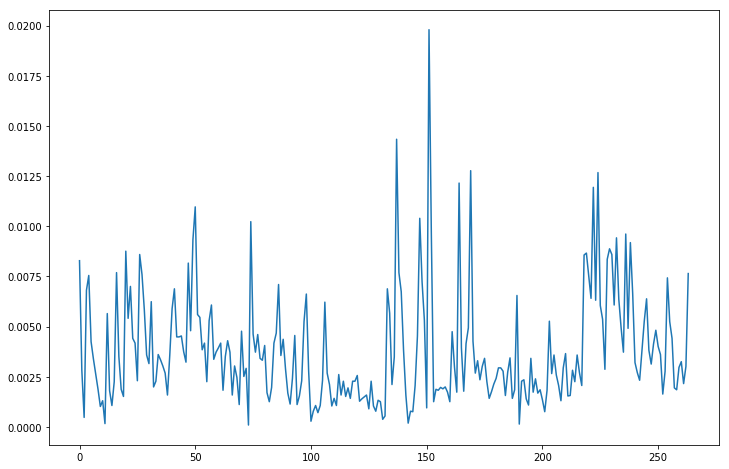

In [597]:
plt.plot(got7.count_daily.values[0])

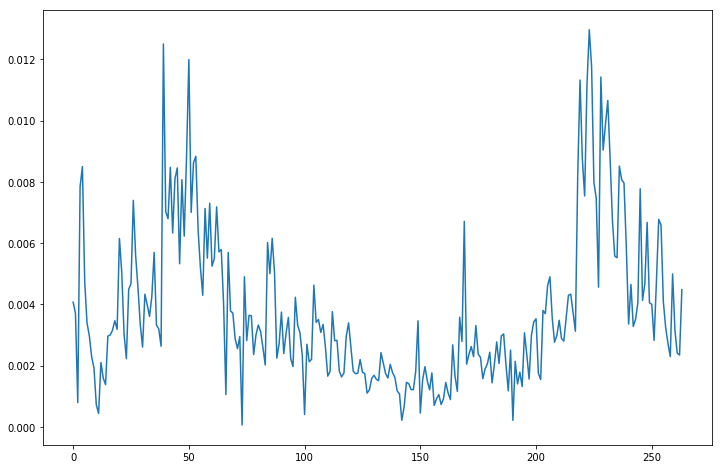

In [594]:
#plt.plot(got7.print_daily.values[0])
plt.plot(got7.count_daily.values[0])

## Analyze of the alphabet used in the hashtag

One interesting point to study is to study if the country of the hashtags impact the number of occurences. In our insights we don't have access to the language of the tweet. However, as the hashtags are some UTF-8 strings, we can extrapolate the alphabet (cyrillic, arabic, chinese, japanese, korean, latin) used. The alphabet itself is a good approximation of the language.

In [77]:
import re
# we first define the character range for the different alphabet in utf-8
cyrillic = "[\u0400-\u04FF\u0500-\u052F]"
arabic = "[\u0600-\u06FF\u0750-\u077F\uFB50-\uFDFF\uFE70-\uFEFF]"
chinese = "[\u2E80-\u2EFF\u3000-\u303F\u3100-\u312F\u31A0-\u31BF\u31C0-\u31EF\u3200-\u32FF\u3300-\u33FF\u3400-\u4DBF\u4E00-\u9FFF\uF900-\uFAFF\uFE30-\uFE4F]"
japanese = "[\u3040-\u309F\u30A0-\u30FF\u31F0-\u31FF]"
korean = "[\u1100-\u11FF\u3130-\u318F\uAC00-\uD7AF]"
re_cyrillic = re.compile(cyrillic, re.UNICODE)
re_arabic = re.compile(arabic, re.UNICODE)
re_chinese = re.compile(chinese, re.UNICODE)
re_japanese = re.compile(japanese, re.UNICODE)
re_korean = re.compile(korean, re.UNICODE)


def approximateCountry(tag):
    """ Given a string [tag], return a string corresponding to the alphabet used"""
    if re_cyrillic.search(tag) is not None:
        return "cyrillic"
    elif re_arabic.search(tag) is not None:
        return "arabic"
    elif re_chinese.search(tag) is not None:
        return "chinese"
    elif re_japanese.search(tag) is not None:
        return "japanese"
    elif re_korean.search(tag) is not None:
        return "korean"
    else:
        return "latin"
    
udfapproximateCountry = F.udf(approximateCountry, StringType())

In [82]:
insights_alphabet = insights_r.withColumn("alphabet", udfapproximateCountry(F.col('tag')))

We first compute the overall proportion of hashtags made in each alphabet.

In [84]:
count = insights_alphabet.count()
proportions = \
    insights_alphabet \
    .groupby('alphabet') \
    .agg(F.count(F.lit(1)) / count) \
    .toPandas()

In [90]:
proportions['alphabet'] = proportions['alphabet'].apply(str.capitalize)

In [91]:
proportions

,alphabet,(count(1) / 119557)
0,Korean,0.093320
1,Cyrillic,0.004776
2,Chinese,0.097385
3,Arabic,0.124376
4,Japanese,0.039655
5,Latin,0.640489


We now compute the proportion of hashtags made in each alphabet for an increasing threshold on the number of occurences of hashtag.
More simply said, we want to know the proportion of hashtags written in chinese among all hashtags occuring more than 250 times, then the proportion for hashtags occuring more than 500 times, etc...

In [92]:
language_df = pd.DataFrame()
thresholds = list(range(250, 100001, 1000))
for t in thresholds:
    filtered = \
        insights_alphabet \
        .where(F.col('count') > t) 
    count = filtered.count()
    temp = \
        filtered \
        .groupby('alphabet') \
        .agg((F.count(F.lit(1)) / count).alias('count_' + str(t))) \
        .toPandas()
    temp['alphabet'] = temp['alphabet'].apply(str.capitalize)
    language_df = pd.concat([language_df, temp.set_index('alphabet').T], ignore_index=True, sort=True)

In [93]:
language_df = language_df.fillna(0)
language_df['threshold'] = thresholds

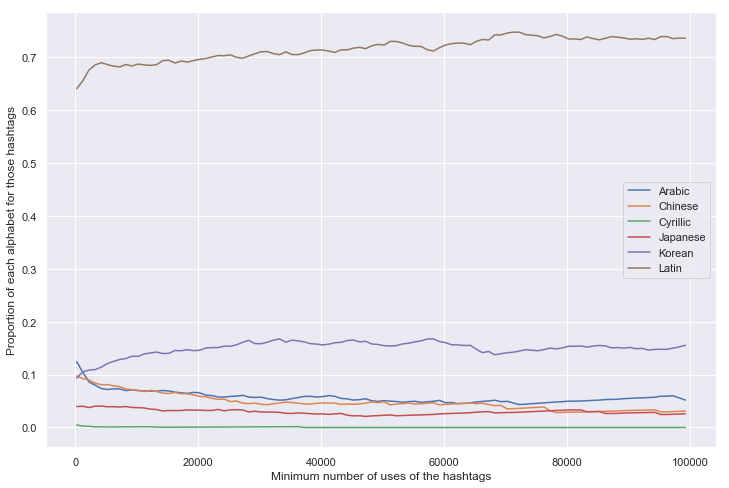

In [94]:
language_df.plot(x='threshold', y=[col for col in language_df.columns if col != 'threshold'])
plt.xlabel('Minimum number of uses of the hashtags')
plt.ylabel('Proportion of each alphabet for those hashtags');

Interestingly, the alphabet used have nearly no influence on the popularity (defined as the count) of an hashtag. The proportion of hashtags written in chinese (for example) is nearly always constant.
We also should notice that the higher the threshold increase, the lower the count of hashtag occuring more than the threshold are.

## Clustering to find similar trends

In the last part of the analysis of hashtags we wanted to explore how to find similar hashtags according to the evolution of the number of occurences in the time. Intuitively, we would want to regroup together hashtags being tweeted every day, regroup together hashtags having one spike of activity... In other words, we want to do some clustering.

However, in our case we are dealing with time series. The euclidean distance will not work correctly, and we want a better metric. The solution is to use dynamic time warping. Dynamic time warping is a metric used to measure the similarity of two temporal sequence. The algorithm behind it is very similar to the levenshtein distance for words. We will be using the implementation fastdtw of the dtw algorithm.

Unfortunately, we can't use kmeans to do our clustering as it is [not efficient with dtw](https://stats.stackexchange.com/questions/131281/dynamic-time-warping-clustering). Pyspark does not have a method for more general clustering, thus prohibiting it to launch our clustering on the whole dataset.

To avoid these limitations we decided to proceed in two steps:
- First we compute the clustering using hierarchical clustering on a subset $X$ of our dataset
- Secondly we extrapolate the clustering of our dataset using knn: for each hashtag, we assign it to the cluster of its nearest neighbors according to dtw.

The first step is to create a sample of our dataset. We are sampling .5% of the dataset without replacement, which is equivalent to 600 hashtags.

In [47]:
sample_ic_pd = insights_compressed.where(F.col('count') > 250).sample(False, .005).toPandas()

In [671]:
from sklearn.cluster import AgglomerativeClustering #For clustering
from scipy.spatial.distance import pdist, squareform
from fastdtw import fastdtw

We then compute the distance matrix of our subset. The distance matrix is a matrix where entry $ij$ is the dtw distance between hashtag $i$ and hashtag $j$

In [672]:
values = sample_ic_pd.count_daily.map(lambda x: np.array(x)).values

In [673]:
dist_matrix =\
    squareform(pdist(
        pd.DataFrame(values.tolist(), index=sample_ic_pd.index), 
        lambda a, b : fastdtw(a, b)[0]))

We then compute the clustering using our precomputed distance matrix. We are looking for 10 clusters.

In [700]:
def doAgglomerative(X, nclust=2):
    model = AgglomerativeClustering(n_clusters=nclust, affinity = 'precomputed', linkage = 'average')
    labels = model.fit_predict(X)
    return labels

labels = doAgglomerative(dist_matrix, 12)

We visualize the output by plotting the time series of 5 hashtags per clusters:

TypeError: must be str, not int

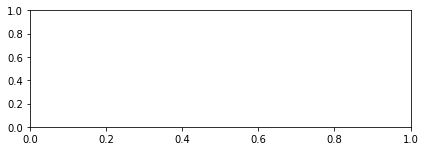

In [702]:
labeled_sample = sample_ic_pd
labeled_sample["label"] = labels
plt.figure(figsize=(15, 15))
plt.tight_layout()
for i in range(len(set(labels))):
    plt.subplot(len(set(labels)) // 2, 2, i + 1)
    plt.title('Cluster ' + (i+1))
    plt.ylim(0, 1)
    which = labeled_sample.label == i
    labeled_sample[which].sample(n=5, replace=True).count_daily.map(lambda r: pd.Series(r).plot())

Unfortunately, we haven't found how to implement k-nn efficiently on the spark dataset. Nethertheless, you can find below our ideas:
- If we want to do 1-nn, we can first do a cartesian product between the dataset $Y$ and our sample $X$, then for each entry compute the dtw distance between the two, then groupby along the tag of the entry in $Y$ and pick the minimum value
- If we want to do k-nn for an other k, we can take the first 10000 entries of the dataset, convert them to a pandas dataframe, use sklearn's k-nn implementation, and repeat for the next 10000 entries.